In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import pickle
import torch.nn as nn
from torch.autograd import Variable
import random

In [2]:
#TODO add split 1-35 train and 36-50 test

## Create dataset

In [3]:
# loading relevancy data

path = 'C:/Users/User/OneDrive - NTNU/NTNU/Prosjekt oppgave NLP/dataset/CORD-19/'
file = 'relevance_data.csv'

label_data = pd.read_csv(path + file)
label_data.head()

,Unnamed: 0,topic_id,round_id,cord_uid,relevancy
0,0,1,4.5,005b2j4b,2
1,1,1,4.0,00fmeepz,1
2,2,1,0.5,010vptx3,2
3,3,1,2.5,0194oljo,1
4,4,1,4.0,021q9884,1


In [4]:
# loading topics data

path = 'C:/Users/User/OneDrive - NTNU/NTNU/Prosjekt oppgave NLP/dataset/CORD-19/'
file = 'topics.csv'

topics = pd.read_csv(path + file)
topics.head()

,query_id,query,question,narrative
0,1,coronavirus origin,what is the origin of COVID-19,seeking range of information about the SARS-Co...
1,2,coronavirus response to weather changes,how does the coronavirus respond to changes in...,seeking range of information about the SARS-Co...
2,3,coronavirus immunity,will SARS-CoV2 infected people develop immunit...,seeking studies of immunity developed due to i...
3,4,how do people die from the coronavirus,what causes death from Covid-19?,Studies looking at mechanisms of death from Co...
4,5,animal models of COVID-19,what drugs have been active against SARS-CoV o...,Papers that describe the results of testing d...


In [5]:
len(label_data)

69318

In [6]:
train_topics = [i+1 for i in range(35)]
test_topics = [i+1 for i in range(35,50)]

In [7]:
# available models: ['bert-base-uncased', "allenai/scibert_scivocab_uncased", "gsarti/covidbert-nli"]

def normalize_tensor(tensor):
    tensor_normed = []
    norm = torch.norm(tensor)
    if norm>0:
        tensor_normed = tensor/norm
    else:
        tensor_normed = tensor
    return tensor_normed

def get_tesors(row, topic_field, doc_field, model):
    topic_path = "C:/Users/User/Documents/NTNU/NLP/CORD-19/topic_embeddings/"
    doc_path = "C:/Users/User/Documents/NTNU/NLP/CORD-19/Embeddings/786/"
    doc_id = row["cord_uid"]
    topic_id = row["topic_id"]
    topic_tensor = []
    doc_tensor = []
    
    doc_embedding_file = doc_path + doc_id + ".txt"
    try:
        with open(doc_embedding_file, "rb") as fp:   # Unpickling
            doc_embedding = pickle.load(fp)
    except:
        return [[0]], [[0]]
        
    doc_tensor = doc_embedding["models"][model][doc_field]
            
    topic_embedding_file = topic_path + str(topic_id) + ".txt"
    with open(topic_embedding_file, "rb") as fp:   # Unpickling
        topic_embedding = pickle.load(fp)
        
    topic_tensor =  topic_embedding["models"][model][topic_field]
    
    topic_tensor = normalize_tensor(topic_tensor)
    doc_tensor = normalize_tensor(doc_tensor)
    
    return topic_tensor, doc_tensor
    

In [8]:
def join_tensors(tensor_a,tensor_b):
    n = len(tensor_a)
    m = len(tensor_b)
    c = torch.empty(n + m)
    c[0:n] = tensor_a
    c[n:(n+m)] = tensor_b
    return c

In [9]:
def isNaN(num):
    return num != num

In [10]:
def load_data(n_datapoints, doc_field, query_field, encoder_model):
    
    topic_dataset = torch.empty(n_datapoints, 768)
    document_dataset = torch.empty(n_datapoints, 768)
    rel = torch.empty(n_datapoints)
    
    miss = 0
    i = 0
    for idx, row in label_data.iterrows():
        if idx < num:
            a, b = get_tesors(row, query_field, doc_field, encoder_model)
            if len(a[0]) != 1:
              
                topic_dataset[i] = a[0]
                document_dataset[i] = b[0]
        
                rel[i] = row["relevancy"]
                i += 1
            else:
                miss += 1
            if(idx % 5000) == 0:
                print(idx)
    
    document_dataset = document_dataset[0:(num-miss)]
    topic_dataset = topic_dataset[0:(num-miss)]
    rel = rel[0:(num-miss)]
    
    return topic_dataset, document_dataset, rel, miss

In [11]:
def load_data_top_id(type_d, doc_field, query_field, encoder_model):
    
    label_dat_top = []
    if type_d == "train":
        label_dat_top = label_data[label_data["topic_id"] < 36]
    else:
        label_dat_top = label_data[label_data["topic_id"] > 35]
        
    n_datapoints = len(label_dat_top["topic_id"])
    print("Number of datapoints for ",type_d," ",n_datapoints)
    topic_dataset = torch.empty(n_datapoints, 768)
    document_dataset = torch.empty(n_datapoints, 768)
    rel = torch.empty(n_datapoints)
    
    miss = 0
    i = 0
    for idx, row in label_dat_top.iterrows():
        a, b = get_tesors(row, query_field, doc_field, encoder_model)
        if len(a[0]) != 1:

            topic_dataset[i] = a[0]
            document_dataset[i] = b[0]

            rel[i] = row["relevancy"]
            i += 1
        else:
            miss += 1
        if(idx % 5000) == 0:
            print(idx)
    
    document_dataset = document_dataset[0:(num-miss)]
    topic_dataset = topic_dataset[0:(num-miss)]
    rel = rel[0:(num-miss)]
    
    return topic_dataset, document_dataset, rel, miss

In [12]:
def join_datasets(doc, query, relevancy, num_class, type_join):
    relevancy_temp = torch.empty(len(relevancy))
    for i , rel in enumerate(relevancy):
        r = rel
        if num_class == 2:
            if rel > 0.01:
                r = 1
        relevancy_temp[i] = r

    n = len(relevancy_temp)
    X_dataset = []
    
    if type_join == "multi":
        X_dataset = torch.empty(n, 768)
        for i in range(n):
            X_dataset[i] = doc[i]*query[i]
    elif type_join == "abs":
        X_dataset = torch.empty(n, 768)
        for i in range(n):
            X_dataset[i] = torch.abs((doc[i] - query[i]))
    else: 
        X_dataset = torch.empty(n, 768*2)
        for i in range(n):
            X_dataset[i] = join_tensors(doc[i],query[i])
    joint_dataset = torch.cat((X_dataset, relevancy_temp.unsqueeze(1)), 1)
    return joint_dataset

In [13]:
#loading 
num = 40000 # max: 69318

available_models = ['bert-base-uncased', "allenai/scibert_scivocab_uncased", "gsarti/covidbert-nli"]
bert_model = available_models[2]
query_field = "query"
doc_field = "title"



In [14]:
label_dat_top = label_data[label_data["topic_id"] < 35]
label_dat_top.head()   

,Unnamed: 0,topic_id,round_id,cord_uid,relevancy
0,0,1,4.5,005b2j4b,2
1,1,1,4.0,00fmeepz,1
2,2,1,0.5,010vptx3,2
3,3,1,2.5,0194oljo,1
4,4,1,4.0,021q9884,1


In [15]:
topic_dat_train, doc_dat_train, rel_dat_train, miss_train  = load_data_top_id("train", doc_field, query_field, bert_model)
topic_dat_test, doc_dat_test, rel_dat_test, miss_test  = load_data_top_id("test", doc_field, query_field, bert_model)

Number of datapoints for  train   52865
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
Number of datapoints for  test   16453
55000
60000
65000


In [238]:

# Possible types: [multi, concat, abs]
joining_type = "abs"

# Model Hyper Parameters 
input_size = 768
if joining_type == "concat":
    input_size = 768*2

# Can use 2 or 3 classes
num_classes = 3

# Training set sub or full
training = "full"




In [239]:
print(list(topic_dat_train.size()))
print(list(doc_dat_train.size()))
print(list(rel_dat_train.size()))
print(list(topic_dat_test.size()))
print(list(doc_dat_test.size()))
print(list(rel_dat_test.size()))

[37937, 768]
[37937, 768]
[37937]
[16453, 768]
[16453, 768]
[16453]


In [240]:

print(rel_dat_train.int().tolist().count(0)/len(rel_dat_train))
print(rel_dat_train.int().tolist().count(1)/len(rel_dat_train))
if num_classes == 3:
    print(rel_dat_train.int().tolist().count(2)/len(rel_dat_train))

print(rel_dat_test.int().tolist().count(0)/len(rel_dat_test))
print(rel_dat_test.int().tolist().count(1)/len(rel_dat_test))
if num_classes == 3:
    print(rel_dat_test.int().tolist().count(2)/len(rel_dat_test))
    



0.6459656799430635
0.16058201755542084
0.19345230250151568
0.5478636114994226
0.1651978362608643
0.2868169938613019


In [241]:
train_data = join_datasets(topic_dat_train, doc_dat_train, rel_dat_train, num_classes, joining_type)
test_data = join_datasets(topic_dat_test, doc_dat_test, rel_dat_test, num_classes, joining_type)

In [242]:
print(list(train_data.size()))
print(list(test_data.size()))
print(train_data[:,input_size])

[37937, 769]
[16453, 769]
tensor([2., 1., 2.,  ..., 2., 1., 0.], grad_fn=<SelectBackward>)


In [243]:
y = train_data[:,input_size]
X = train_data[:,0:(input_size)]

if training == "full":
    y = torch.cat((train_data[:,input_size],test_data[:,input_size]))
    X = torch.cat((train_data[:,0:(input_size)] ,test_data[:,0:(input_size)] ))
print(list(X.size()))
print(list(y.size()))

[54390, 768]
[54390]


model

$$
    \hat{\beta} = (X^TX)^{-1}X^Ty
$$

Fitting the model

In [244]:
l = X.t()
print(list(l.size()))
print(list(X.size()))
l = torch.mm(l, X)
print(list(l.size()))
l = torch.inverse(l)
print(list(l.size()))
l = torch.mm(l,X.t())
print(list(l.size()))
print(list(y.t().size()))
beta_hat = torch.mv(l,y)
print(list(beta_hat.size()))

[768, 54390]
[54390, 768]
[768, 768]
[768, 768]
[768, 54390]
[54390]
[768]


In [245]:
print(beta_hat.tolist())

[1.2206486463546753, -2.2899551391601562, -1.3862780332565308, 2.3471317291259766, 0.7623217105865479, -0.24870091676712036, -0.9258395433425903, -3.2108561992645264, 0.8017182350158691, 0.7199126482009888, -0.9987918138504028, 0.5267919301986694, -0.6276278495788574, 1.027318000793457, 1.4180384874343872, -0.23857372999191284, -0.7850512862205505, -0.04300212860107422, 0.43746066093444824, 1.1916028261184692, 0.7341361045837402, 0.9358571767807007, 3.23012375831604, -0.06331521272659302, 1.7600364685058594, -0.24068665504455566, -0.2846471965312958, -4.641317367553711, 0.4588947594165802, -0.7063465714454651, 0.6996437311172485, 0.11399827897548676, -2.3020100593566895, 1.1085178852081299, 0.08491866290569305, -1.00325608253479, 1.457753300666809, -1.0699517726898193, 1.5103063583374023, 2.7706751823425293, -1.2231197357177734, -1.9195080995559692, 5.611811637878418, 0.631514310836792, 1.094817876815796, 4.043010234832764, 0.7182504534721375, 0.7049270868301392, -0.8663316965103149, 0

In [246]:
y_test = test_data[:,input_size]
X_test = test_data[:,0:(input_size)]

In [247]:
# Prediction from the model
y_hat =  torch.mv(X_test,beta_hat)

In [248]:
for i in range(100):
    print((y_hat[i] - y_test[i]))
    print((y_hat[i] , y_test[i]))

tensor(-0.7243, grad_fn=<SubBackward0>)
(tensor(1.2757, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(-0.8583, grad_fn=<SubBackward0>)
(tensor(1.1417, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(-0.9906, grad_fn=<SubBackward0>)
(tensor(1.0094, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(-1.0397, grad_fn=<SubBackward0>)
(tensor(0.9603, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(0.6765, grad_fn=<SubBackward0>)
(tensor(0.6765, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>))
tensor(0.8938, grad_fn=<SubBackward0>)
(tensor(0.8938, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>))
tensor(-0.6605, grad_fn=<SubBackward0>)
(tensor(1.3395, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(-0.1214, grad_fn=<SubBackward0>)
(tensor(0.8786, grad_fn=<SelectBackward>), tensor(1., grad_fn=<SelectBackward>))
tensor(-0.9639, grad_fn=<SubBackwa

(tensor(0.6271, grad_fn=<SelectBackward>), tensor(1., grad_fn=<SelectBackward>))
tensor(-1.3543, grad_fn=<SubBackward0>)
(tensor(0.6457, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(-0.9068, grad_fn=<SubBackward0>)
(tensor(1.0932, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(0.6200, grad_fn=<SubBackward0>)
(tensor(0.6200, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>))
tensor(-1.0553, grad_fn=<SubBackward0>)
(tensor(0.9447, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(-0.6278, grad_fn=<SubBackward0>)
(tensor(1.3722, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(-1.2194, grad_fn=<SubBackward0>)
(tensor(0.7806, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(-0.7491, grad_fn=<SubBackward0>)
(tensor(1.2509, grad_fn=<SelectBackward>), tensor(2., grad_fn=<SelectBackward>))
tensor(-0.9830, grad_fn=<SubBackward0>)
(tensor(1.0170, grad_fn=<SelectBa

In [249]:
diff = (y_hat - y_test)**2

[5.2460569e-01 7.3667514e-01 9.8122007e-01 ... 5.0251392e-06 0.0000000e+00
 5.0252061e-06]


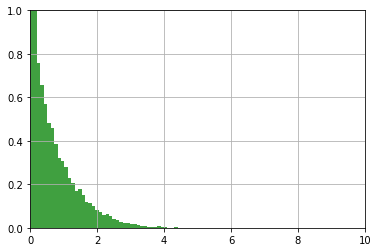

In [250]:
import numpy as np
import matplotlib.pyplot as plt

print(diff.detach().numpy(),)

# the histogram of the data
n, bins, patches = plt.hist(diff.detach().numpy(), 50, density=True, facecolor='g', alpha=0.75)

#pltting the results

plt.xlim(0, 10)
plt.ylim(0, 1)

plt.grid(True)
plt.show()

In [251]:
import numpy as np
from sklearn import metrics
y_pred = y_hat.detach().numpy()
y =  np.asarray(y_test.detach().numpy(), dtype=int)
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.6320092050381807

In [252]:
import numpy as np
from sklearn import metrics
y_temp = torch.sum(X_test, 1)
print(list(y_temp.size()))
y_pred = y_temp.detach().numpy()
y =  np.asarray(y_test.detach().numpy(), dtype=int)
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=1)
print(fpr, tpr)
metrics.auc(fpr, tpr)

[16453]
[0.00000000e+00 0.00000000e+00 4.36840189e-04 ... 9.26465235e-01
 9.26683655e-01 1.00000000e+00] [0.00000000e+00 3.67917586e-04 3.67917586e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


0.5613070838131531

In [253]:


print(rel_dat_train.int().tolist().count(0)/len(rel_dat_train))
print(rel_dat_train.int().tolist().count(1)/len(rel_dat_train))
if num_classes == 3:
    print(rel_dat_train.int().tolist().count(2)/len(rel_dat_train))

print(rel_dat_test.int().tolist().count(0)/len(rel_dat_test))
print(rel_dat_test.int().tolist().count(1)/len(rel_dat_test))
if num_classes == 3:
    print(rel_dat_test.int().tolist().count(2)/len(rel_dat_test))
    



0.6459656799430635
0.16058201755542084
0.19345230250151568
0.5478636114994226
0.1651978362608643
0.2868169938613019
